DQ Telco merupakan perusahaan Telco yang sudah mempunyai banyak cabang tersebar dimana-mana. Sejak berdiri pada tahun 2019, DQ Telco konsisten untuk memperhatikan customer experience-nya sehingga tidak akan ditinggalkan pelanggan.

Walaupun baru berumur 1 tahun lebih sedikit, DQ Telco sudah mempunyai banyak pelanggan yang beralih langganan ke kompetitor. Pihak management ingin mengurangi jumlah pelanggan yang beralih (churn) dengan menggunakan machine learning.

Oleh karena itu, kita akan membuat model prediksi yang tepat untuk menentukan pelanggan akan berhenti berlangganan (churn) atau tidak.

[Dataset]('https://storage.googleapis.com/dqlab-dataset/dqlab_telco.csv')


In [ ]:
#Import library yang dibutuhkan 
#importing general packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
import pickle
from pathlib import Path

pd.options.display.max_columns = 50

In [ ]:
#import dataset
df_load = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/dqlab_telco.csv')

#Tampilkan jumlah baris dan kolom
print(df_load.shape)

#Tampilkan 5 data teratas
print(df_load.head(5))

#Jumlah ID yang unik
print(df_load.customerID.nunique())

(7113, 22)
   UpdatedAt   customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     202006  45759018157  Female              0     Yes         No     1.0   
1     202006  45557574145    Male              0      No         No    34.0   
2     202006  45366876421    Male              0      No         No     2.0   
3     202006  45779536532    Male              0      No         No    45.0   
4     202006  45923787906  Female              0      No         No     2.0   

  PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup  \
0           No  No phone service             DSL             No          Yes   
1          Yes                No             DSL            Yes           No   
2          Yes                No             DSL            Yes          Yes   
3           No  No phone service             DSL            Yes           No   
4          Yes                No     Fiber optic             No           No   

  DeviceProtection TechSupport St

##Mencari Validitas ID Number Pelanggan

Memfilter ID Number Pelanggan Format Tertentu

Mencari format ID Number (Phone Number) Pelanggan customerID yang benar, dengan kriteria:

Panjang karakter adalah 11-12.
Terdiri dari angka Saja, tidak diperbolehkan ada karakter selain angka
Diawali dengan angka 45 2 digit pertama.


In [ ]:
df_load['valid_id'] = df_load['customerID'].astype(str).str.match(r'(45\d{9,10})')

df_load = (df_load[df_load['valid_id']==True]).drop('valid_id', axis=1)
print('Hasil jumlah ID Customer yang terfilter adalah', df_load['customerID'].count())																 

Hasil jumlah ID Customer yang terfilter adalah 7006


##Memfilter Duplikasi ID Number Pelanggan

In [ ]:
# Drop Duplicate Rows
df_load.drop_duplicates()
# Drop duplicate ID sorted by Periode
df_load = df_load.sort_values('UpdatedAt', ascending=False).drop_duplicates(['customerID'])
print('Hasil jumlah ID Customer yang sudah dihilangkan duplikasinya (distinct) adalah',df_load['customerID'].count())

Hasil jumlah ID Customer yang sudah dihilangkan duplikasinya (distinct) adalah 6993


##Mengatasi Missing Values dengan Penghapusan Rows

In [ ]:
print('Status Missing Values :',df_load.isnull().values.any())
print('\nJumlah Missing Values masing-masing kolom, adalah:')
print(df_load.isnull().sum().sort_values(ascending=False))

# handling missing values Tenure fill with 11
df_load['tenure'].fillna(11, inplace=True)

# Handling missing values num vars (except Tenure)
for col_name in list(['MonthlyCharges','TotalCharges']):
	median = df_load[col_name].median()
	df_load[col_name].fillna(median, inplace=True)

df_load = df_load.dropna()

print('\nJumlah Missing Values setelah di imputer datanya, adalah:')
print(df_load.isnull().sum().sort_values(ascending=False))

Status Missing Values : True

Jumlah Missing Values masing-masing kolom, adalah:
tenure              99
Churn               43
MonthlyCharges      26
TotalCharges        15
DeviceProtection     0
PaymentMethod        0
PaperlessBilling     0
Contract             0
StreamingMovies      0
StreamingTV          0
TechSupport          0
UpdatedAt            0
customerID           0
OnlineSecurity       0
InternetService      0
MultipleLines        0
PhoneService         0
Dependents           0
Partner              0
SeniorCitizen        0
gender               0
OnlineBackup         0
dtype: int64

Jumlah Missing Values setelah di imputer datanya, adalah:
Churn               43
customerID           0
TotalCharges         0
MonthlyCharges       0
PaymentMethod        0
PaperlessBilling     0
Contract             0
StreamingMovies      0
StreamingTV          0
TechSupport          0
DeviceProtection     0
UpdatedAt            0
OnlineSecurity       0
InternetService      0
MultipleLines      

##Mendeteksi adanya Outlier (Boxplot)


Persebaran data sebelum ditangani Outlier: 
            tenure  MonthlyCharges  TotalCharges
count  6950.000000     6950.000000   6950.000000
mean     32.477266       65.783741   2305.089989
std      25.188910       50.457871   2578.648857
min       0.000000        0.000000     19.000000
25%       9.000000       36.462500    406.975000
50%      29.000000       70.450000   1403.875000
75%      55.000000       89.850000   3799.837500
max     500.000000     2311.000000  80000.000000


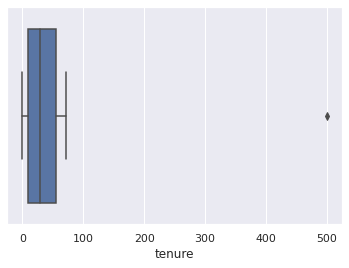

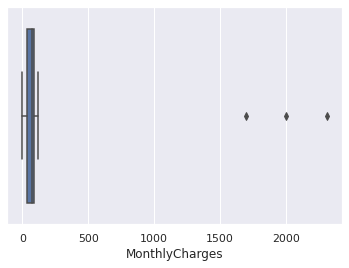

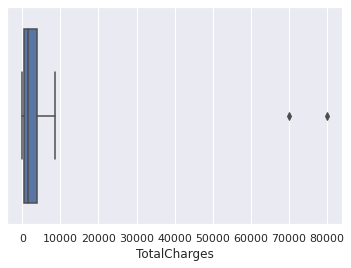

In [ ]:
print('\nPersebaran data sebelum ditangani Outlier: ')
print(df_load[['tenure','MonthlyCharges','TotalCharges']].describe())

# Creating Box Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Masukkan variable
plt.figure() # untuk membuat figure baru
sns.boxplot(x=df_load['tenure'])
plt.show()
plt.figure() # untuk membuat figure baru
sns.boxplot(x=df_load['MonthlyCharges'])
plt.show()
plt.figure() # untuk membuat figure baru
sns.boxplot(x=df_load['TotalCharges'])
plt.show()

##Mengatasi Outlier

In [ ]:
# Handling with IQR
Q1 = (df_load[['tenure','MonthlyCharges','TotalCharges']]).quantile(0.25)
Q3 = (df_load[['tenure','MonthlyCharges','TotalCharges']]).quantile(0.75)

IQR = Q3 - Q1
maximum = Q3 + (1.5*IQR)
print('Nilai Maximum dari masing-masing Variable adalah: ')
print(maximum)
minimum = Q1 - (1.5*IQR)
print('\nNilai Minimum dari masing-masing Variable adalah: ')
print(minimum)

more_than = (df_load > maximum)
lower_than = (df_load < minimum)
df_load = df_load.mask(more_than, maximum, axis=1)
df_load = df_load.mask(lower_than, minimum, axis=1)

print('\nPersebaran data setelah ditangani Outlier: ')
print(df_load[['tenure','MonthlyCharges','TotalCharges']].describe())

Nilai Maximum dari masing-masing Variable adalah: 
tenure             124.00000
MonthlyCharges     169.93125
TotalCharges      8889.13125
dtype: float64

Nilai Minimum dari masing-masing Variable adalah: 
tenure             -60.00000
MonthlyCharges     -43.61875
TotalCharges     -4682.31875
dtype: float64

Persebaran data setelah ditangani Outlier: 
            tenure  MonthlyCharges  TotalCharges
count  6950.000000     6950.000000   6950.000000
mean     32.423165       64.992201   2286.065279
std      24.581073       30.032040   2265.700006
min       0.000000        0.000000     19.000000
25%       9.000000       36.462500    406.975000
50%      29.000000       70.450000   1403.875000
75%      55.000000       89.850000   3799.837500
max     124.000000      169.931250   8889.131250


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  


##Mendeteksi Nilai yang tidak Standar

In [ ]:
# Masukkan variable
for col_name in list(['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','Churn']):
	print('\nUnique Values Count \033[1m' + 'Before Standardized \033[0m Variable',col_name)
	print(df_load[col_name].value_counts())


Unique Values Count Before Standardized  Variable gender
Male         3499
Female       3431
Wanita         14
Laki-Laki       6
Name: gender, dtype: int64

Unique Values Count Before Standardized  Variable SeniorCitizen
0    5822
1    1128
Name: SeniorCitizen, dtype: int64

Unique Values Count Before Standardized  Variable Partner
No     3591
Yes    3359
Name: Partner, dtype: int64

Unique Values Count Before Standardized  Variable Dependents
No     4870
Yes    2060
Iya      20
Name: Dependents, dtype: int64

Unique Values Count Before Standardized  Variable PhoneService
Yes    6281
No      669
Name: PhoneService, dtype: int64

Unique Values Count Before Standardized  Variable MultipleLines
No                  3346
Yes                 2935
No phone service     669
Name: MultipleLines, dtype: int64

Unique Values Count Before Standardized  Variable InternetService
Fiber optic    3057
DSL            2388
No             1505
Name: InternetService, dtype: int64

Unique Values Count Befor

##Menstandarisasi Variable Kategorik

In [ ]:
df_load = df_load.replace(['Wanita','Laki-Laki','Churn','Iya'],['Female','Male','Yes','Yes'])

# Masukkan variable
for col_name in list(['gender','Dependents','Churn']):
	print('\nUnique Values Count \033[1m' + 'After Standardized \033[0mVariable',col_name)
	print(df_load[col_name].value_counts())


Unique Values Count After Standardized Variable gender
Male      3505
Female    3445
Name: gender, dtype: int64

Unique Values Count After Standardized Variable Dependents
No     4870
Yes    2080
Name: Dependents, dtype: int64

Unique Values Count After Standardized Variable Churn
No     5114
Yes    1836
Name: Churn, dtype: int64


# Exploratory Data Analysis (EDA)

##Memvisualisasikan Prosentase Churn

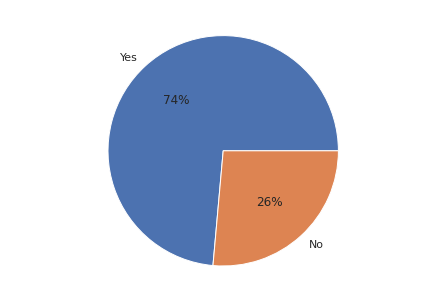

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
labels = ['Yes','No']
churn = df_load.Churn.value_counts()
ax.pie(churn, labels=labels, autopct='%.0f%%')
plt.show()

## Exploratory Data Analysis (EDA) Variabel Numerik

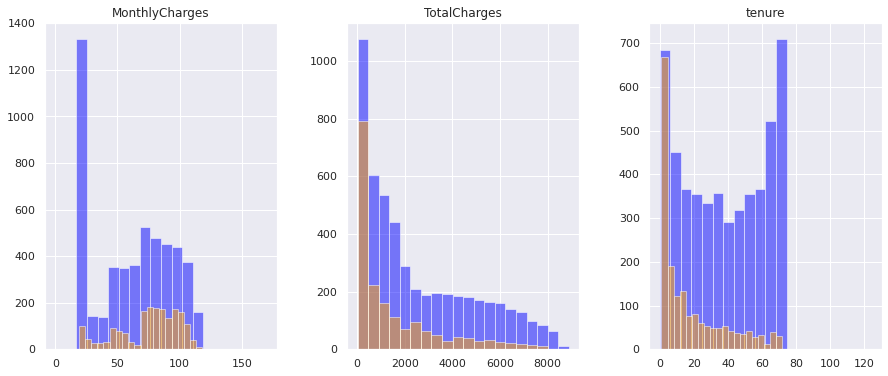

In [ ]:
#creating bin in chart
numerical_features = ['MonthlyCharges','TotalCharges','tenure']
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
# Use the following code to plot two overlays of histogram per each numerical_features, use a color of blue and orange, respectively
df_load[df_load.Churn == 'No'][numerical_features].hist(bins=20, color='blue', alpha=0.5, ax=ax)
df_load[df_load.Churn == 'Yes'][numerical_features].hist(bins=20, color='orange', alpha=0.5, ax=ax)
plt.show()

##Exploratory Data Analysis (EDA) Variabel Kategorik

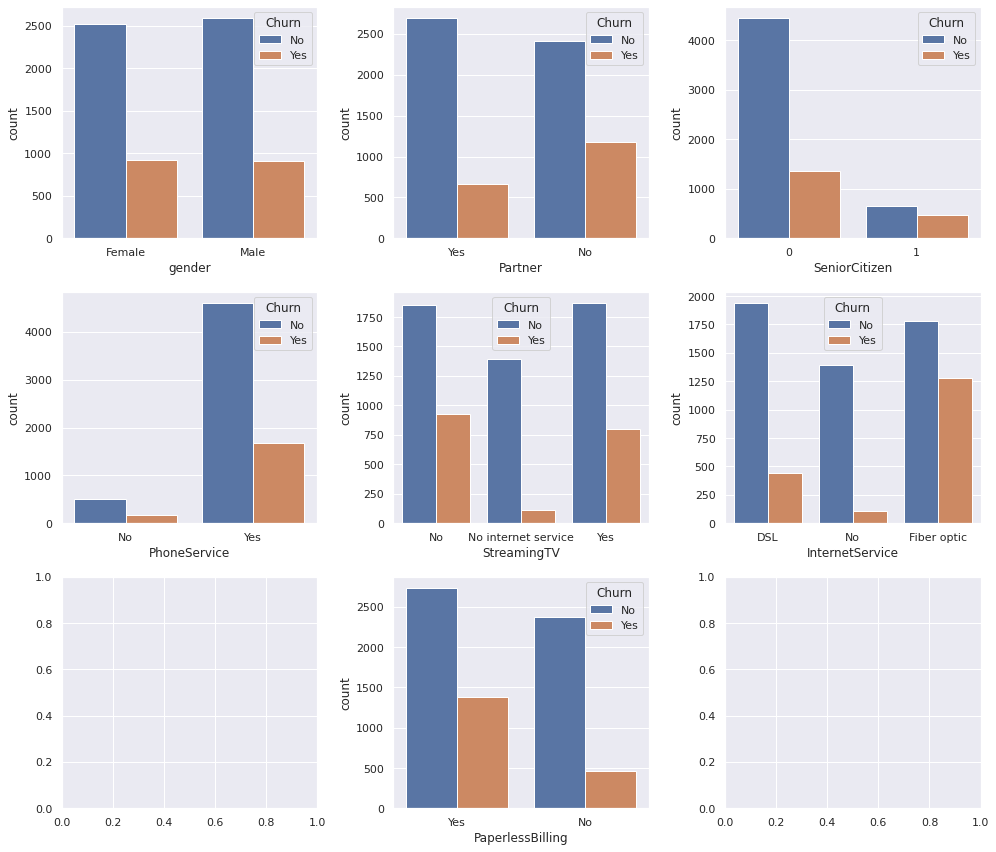

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(14, 12))
sns.countplot(data=df_load, x='gender', hue='Churn', ax=ax[0][0])
sns.countplot(data=df_load, x='Partner', hue='Churn', ax=ax[0][1])
sns.countplot(data=df_load, x='SeniorCitizen', hue='Churn', ax=ax[0][2])
sns.countplot(data=df_load, x='PhoneService', hue='Churn', ax=ax[1][0])
sns.countplot(data=df_load, x='StreamingTV', hue='Churn', ax=ax[1][1])
sns.countplot(data=df_load, x='InternetService', hue='Churn', ax=ax[1][2])
sns.countplot(data=df_load, x='PaperlessBilling', hue='Churn', ax=ax[2][1])
plt.tight_layout()
plt.show()

pada tahap C.1 dapat kita ketahui bahwa sebaran data secara kesuluruhan customer tidak melakukan churn, dengan detil Churn sebanyak 26% dan No Churn sebanyak 74%.

pada tahap C.2 dapat kita ketahui bahwa untuk MonthlyCharges ada kecenderungan semakin kecil nilai biaya bulanan yang dikenakan, semakin kecil juga kecenderungan untuk melakukan Churn. Untuk TotalCharges terlihat tidak ada kecenderungan apapun terhadap Churn customers. Untuk tenure ada kecenderungan semakin lama berlangganan customer, semakin kecil kecenderungan untuk melakukan Churn.

pada tahap C.3 dapat kita ketahui bahwa tidak ada perbedaan yang signifikan untuk orang melakukan churn dilihat dari faktor jenis kelamin (gender) dan layanan telfonnya (PhoneService). Akan tetapi ada kecenderungan bahwa orang yang melakukan churn adalah orang-orang yang tidak memiliki partner (partner: No), orang-orang yang statusnya adalah senior citizen(SeniorCitizen: Yes), orang-orang yang mempunyai layanan streaming TV (StreamingTV: Yes), orang-orang yang mempunyai layanan Internet (internetService: Yes) dan orang-orang yang tagihannya paperless (PaperlessBilling: Yes).


#Data PreProcessing

##Menghapus Unnecessary Columns dari data

In [ ]:
#Remove the unnecessary columns customerID & UpdatedAt
cleaned_df = df_load.drop(['customerID','UpdatedAt'],axis=1)
print(cleaned_df.head())

      gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0     Female              0     Yes         No     1.0           No   
4727    Male              0     Yes         No    60.0          Yes   
4738    Male              0      No         No     5.0          Yes   
4737  Female              0     Yes         No    72.0          Yes   
4736  Female              0     Yes        Yes    56.0          Yes   

         MultipleLines InternetService       OnlineSecurity  \
0     No phone service             DSL                   No   
4727                No              No  No internet service   
4738               Yes     Fiber optic                   No   
4737               Yes     Fiber optic                  Yes   
4736               Yes             DSL                  Yes   

             OnlineBackup     DeviceProtection          TechSupport  \
0                     Yes                   No                   No   
4727  No internet service  No internet service  No i

##Encoding Data

In [ ]:
from sklearn.preprocessing import LabelEncoder
#Convert all the non-numeric columns to numerical data types
for column in cleaned_df.columns:
	if cleaned_df[column].dtype == np.number: continue
	# Perform encoding for each non-numeric column
	cleaned_df[column] = LabelEncoder().fit_transform(cleaned_df[column])
print(cleaned_df.describe())

            gender  SeniorCitizen      Partner   Dependents       tenure  \
count  6950.000000    6950.000000  6950.000000  6950.000000  6950.000000   
mean      0.504317       0.162302     0.483309     0.299281    32.423165   
std       0.500017       0.368754     0.499757     0.457976    24.581073   
min       0.000000       0.000000     0.000000     0.000000     0.000000   
25%       0.000000       0.000000     0.000000     0.000000     9.000000   
50%       1.000000       0.000000     0.000000     0.000000    29.000000   
75%       1.000000       0.000000     1.000000     1.000000    55.000000   
max       1.000000       1.000000     1.000000     1.000000   124.000000   

       PhoneService  MultipleLines  InternetService  OnlineSecurity  \
count   6950.000000    6950.000000      6950.000000     6950.000000   
mean       0.903741       0.940863         0.872950        0.789496   
std        0.294967       0.948880         0.737618        0.859795   
min        0.000000       0.000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  after removing the cwd from sys.path.


##Splitting Dataset

In [ ]:
from sklearn.model_selection import train_test_split
# Predictor dan target
X = cleaned_df.drop('Churn', axis = 1)
y = cleaned_df['Churn']
# Splitting train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Print according to the expected result
print('Jumlah baris dan kolom dari x_train adalah:', x_train.shape,', sedangkan Jumlah baris dan kolom dari y_train adalah:', y_train.shape)
print('Prosentase Churn di data Training adalah:')
print(y_train.value_counts(normalize=True))
print('Jumlah baris dan kolom dari x_test adalah:', x_test.shape,', sedangkan Jumlah baris dan kolom dari y_test adalah:', y_test.shape)
print('Prosentase Churn di data Testing adalah:')
print(y_test.value_counts(normalize=True))

Jumlah baris dan kolom dari x_train adalah: (4865, 19) , sedangkan Jumlah baris dan kolom dari y_train adalah: (4865,)
Prosentase Churn di data Training adalah:
0    0.734841
1    0.265159
Name: Churn, dtype: float64
Jumlah baris dan kolom dari x_test adalah: (2085, 19) , sedangkan Jumlah baris dan kolom dari y_test adalah: (2085,)
Prosentase Churn di data Testing adalah:
0    0.738129
1    0.261871
Name: Churn, dtype: float64


#Modelling: Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression().fit(x_train, y_train)
print('Model Logistic Regression yang terbentuk adalah: \n', log_model)

Model Logistic Regression yang terbentuk adalah: 
 LogisticRegression()


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


##Performansi Model Training - Menampilkan Metrics

Classification Report Training Model (Logistic Regression) :
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      3575
           1       0.64      0.56      0.60      1290

    accuracy                           0.80      4865
   macro avg       0.75      0.72      0.73      4865
weighted avg       0.79      0.80      0.80      4865



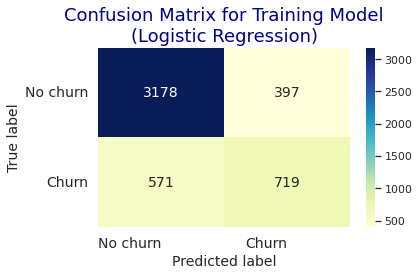

In [ ]:
from sklearn.metrics import classification_report
# Predict
y_train_pred = log_model.predict(x_train)
# Print classification report
print('Classification Report Training Model (Logistic Regression) :')
print(classification_report(y_train, y_train_pred))

# Form confusion matrix as a DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), 
                                   ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Logistic Regression)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

#Performansi Data Testing - Menampilkan Metrics

Classification Report Testing Model (Logistic Regression):
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1539
           1       0.66      0.53      0.59       546

    accuracy                           0.80      2085
   macro avg       0.75      0.72      0.73      2085
weighted avg       0.79      0.80      0.80      2085



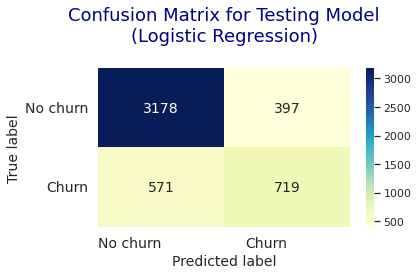

In [ ]:
# Predict
y_test_pred = log_model.predict(x_test)
# Print classification report
print('Classification Report Testing Model (Logistic Regression):')
print(classification_report(y_test, y_test_pred))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Logistic Regression)\n', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

Dari hasil dan analisa di atas, maka:

Jika kita menggunakan menggunakan algoritma logistic regression dengan memanggil LogisticRegression() dari sklearn tanpa menambahi parameter apapun, maka yang dihasilkan adalah model dengan seting default dari sklearn, untuk detilnya bisa dilihat di dokumentasinya.
Dari data training terlihat bahwasannya model mampu memprediksi data dengan menghasilkan akurasi sebesar 80%, dengan detil tebakan churn yang sebenernya benar churn adalah 638, tebakan tidak churn yang sebenernya tidak churn adalah 3237, tebakan tidak churn yang sebenernya benar churn adalah 652 dan tebakan churn yang sebenernya tidak churn adalah 338.
Dari data testing terlihat bahwasannya model mampu memprediksi data dengan menghasilkan akurasi sebesar 79%, dengan detil tebakan churn yang sebenernya benar churn adalah 264, tebakan tidak churn yang sebenernya tidak churn adalah 1392, tebakan tidak churn yang sebenernya benar churn adalah 282 dan tebakan churn yang sebenernya tidak churn adalah 146.


#Modelling : Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#Train the model
rdf_model = RandomForestClassifier().fit(x_train, y_train)
print(rdf_model)

RandomForestClassifier()


In [ ]:
y_train_pred = rdf_model.predict(x_train)
print('Classification Report Training Model (Random Forest Classifier) :')
print(classification_report(y_train, y_train_pred))

Classification Report Training Model (Random Forest Classifier) :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3575
           1       1.00      0.99      1.00      1290

    accuracy                           1.00      4865
   macro avg       1.00      1.00      1.00      4865
weighted avg       1.00      1.00      1.00      4865



##Performansi Data Training - Menampilkan Plots

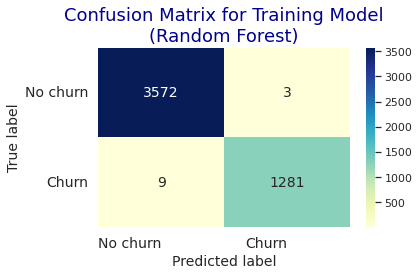

In [ ]:

# Form confusion matrix as a DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Random Forest)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:

# Predict
y_test_pred = rdf_model.predict(x_test)
# Print classification report
print('Classification Report Testing Model (Random Forest Classifier):')
print(classification_report(y_test, y_test_pred))

Classification Report Testing Model (Random Forest Classifier):
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1539
           1       0.67      0.48      0.56       546

    accuracy                           0.80      2085
   macro avg       0.75      0.70      0.72      2085
weighted avg       0.79      0.80      0.79      2085



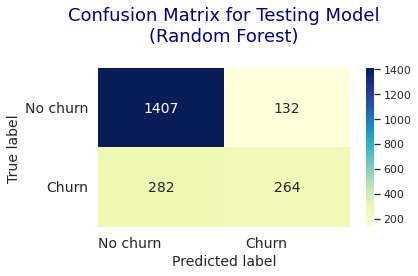

In [ ]:
# Form confusion matrix as a DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)

plt.title('Confusion Matrix for Testing Model\n(Random Forest)\n', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.tight_layout()
plt.show()

Dari hasil dan analisa di atas, maka:

Jika kita menggunakan menggunakan algoritma Random Forest dengan memanggil RandomForestClassifier() dari sklearn tanpa menambahi parameter apapun, maka yang dihasilkan adalah model dengan seting default dari sklearn, untuk detilnya bisa dilihat di dokumentasinya.
Dari data training terlihat bahwasannya model mampu memprediksi data dengan menghasilkan akurasi sebesar 100%, dengan detil tebakan churn yang sebenernya benar churn adalah 1278, tebakan tidak churn yang sebenernya tidak churn adalah 3566, tebakan tidak churn yang sebenernya benar churn adalah 12 dan tebakan churn yang sebenernya tidak churn adalah 9.
Dari data testing terlihat bahwasannya model mampu memprediksi data dengan menghasilkan akurasi sebesar 78%, dengan detil tebakan churn yang sebenernya benar churn adalah 262, tebakan tidak churn yang sebenernya tidak churn adalah 1360, tebakan tidak churn yang sebenernya benar churn adalah 284 dan tebakan churn yang sebenernya tidak churn adalah 179.

#Modelling: Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
#Train the model
gbt_model = GradientBoostingClassifier().fit(x_train, y_train)
print(gbt_model)

GradientBoostingClassifier()


In [ ]:
# Predict
y_train_pred = gbt_model.predict(x_train)
# Print classification report
print('Classification Report Training Model (Gradient Boosting):')
print(classification_report(y_train, y_train_pred))

Classification Report Training Model (Gradient Boosting):
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      3575
           1       0.73      0.58      0.64      1290

    accuracy                           0.83      4865
   macro avg       0.79      0.75      0.77      4865
weighted avg       0.82      0.83      0.82      4865



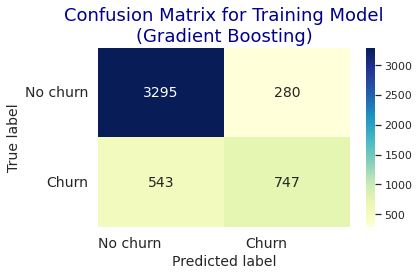

In [ ]:
# Form confusion matrix as a DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)

plt.title('Confusion Matrix for Training Model\n(Gradient Boosting)', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.tight_layout()
plt.show()

In [ ]:
# Predict
y_test_pred = gbt_model.predict(x_test)
# Print classification report 
print('Classification Report Testing Model (Gradient Boosting):')
print(classification_report(y_test, y_test_pred))

Classification Report Testing Model (Gradient Boosting):
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1539
           1       0.68      0.51      0.59       546

    accuracy                           0.81      2085
   macro avg       0.76      0.71      0.73      2085
weighted avg       0.80      0.81      0.80      2085



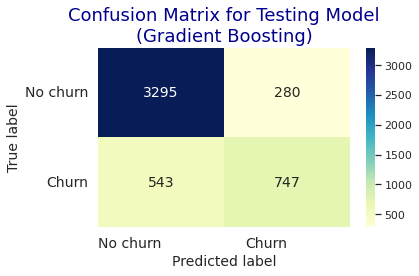

In [ ]:
# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Gradient Boosting)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

Berdasarkan pemodelan yang telah dilakukan dengan menggunakan Logistic Regression, Random Forest dan Extreme Gradiant Boost, maka dapat disimpulkan untuk memprediksi churn dari pelanggan telco dengan menggunakan dataset ini model terbaiknya adalah menggunakan algortima Logistic Regression. Hal ini dikarenakan performa dari model Logistic Regression cenderung mampu memprediksi sama baiknya di fase training maupun testing (akurasi training 80%, akurasi testing 79%), dilain sisi algoritma lainnya cenderung Over-Fitting performanya. Akan tetapi hal ini tidak menjadikan kita untuk menarik kesimpulan bahwsannya jika untuk melakukan pemodelan apapun maka digunakan Logistic Regression, kita tetap harus melakukan banyak percobaan model untuk menentukan mana yang terbaik.

